In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from copy import deepcopy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns
from math import ceil

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
from utils import get_field_metrics
import configs

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Collect metrics over datasets
You will have to run the corresponding python file to this jupyter notebook (will have the same title, but with 'parfor' attached).

In [35]:
gamma = 0.75
model = 'rnn'

In [36]:
with open(f'./pickles/5a_{model}_results_gamma{gamma}.p', 'rb') as f:
    results = pickle.load(f)

In [37]:
results.keys()

dict_keys(['gamma', 'arena_length', 'init_sparsities', 'sigmas', 'final_sparsities', 'fieldsizes', 'nfields', 'onefields'])

In [38]:
arena_length = np.array(results['arena_length'])
init_sparsities = np.array(results['init_sparsities'])
sigmas = np.array(results['sigmas'])
final_sparsities = np.array(results['final_sparsities'])
fieldsizes = np.array(results['fieldsizes']) - 0.07
nfields = np.array(results['nfields']) - 1.6
onefields = np.array(results['onefields']) - 0.55

In [39]:
df = pd.DataFrame({
    'Seed Sparsity': init_sparsities,
    'Spatial Corr.': sigmas,
    'Sparsity': final_sparsities,
    'Field Size': fieldsizes,
    'Fields per Neuron': nfields,
    'Single Field Neurons': onefields
    })

In [63]:
nfields

array([ 1.4275e+00,  1.5575e+00, -8.2500e-02, -1.7250e-01, -1.2000e-01,
        7.6250e-01,  7.4000e-01,  7.1500e-01,  2.8725e+00,  3.1325e+00,
        2.7750e+00,  2.7850e+00,  3.0175e+00,  2.9225e+00,  3.3750e-01,
        3.6500e-01,  3.7750e-01,  1.2900e+00,  7.0000e-02,  6.7500e-02,
        7.5000e-03,  9.0000e-02,  1.2750e-01,  1.6250e-01,  1.1875e+00,
        1.1625e+00,  4.0000e-02, -9.5000e-02, -6.7500e-02,  7.7750e-01,
        7.6500e-01,  1.1100e+00,  1.3550e+00,  1.1500e+00,  1.2400e+00,
        1.2575e+00,  1.3075e+00,  5.5000e-01,  5.7250e-01,  5.5000e-01,
        4.3500e-01,  4.6000e-01,  4.3500e-01,  1.1750e-01,  6.7500e-02,
        7.0000e-02,  2.0500e-01,  2.1000e-01,  2.4250e-01,  1.5450e+00,
        1.4825e+00,  1.7650e+00,  1.1000e-01,  2.1250e-01,  1.1000e-01,
        9.4500e-01,  8.8250e-01,  2.3075e+00,  2.0550e+00,  2.5850e+00,
        3.0775e+00,  3.1400e+00,  3.1875e+00,  3.7250e-01,  5.5500e-01,
        3.6250e-01, -5.1000e-01, -1.5500e-01,  2.4500e-01,  2.60

# Make gradient plots

In [40]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [53]:
value = nfields

In [54]:
xs = np.sort(np.unique(init_sparsities))
ys = np.sort(np.unique(sigmas))

In [55]:
dx = xs[1:] - xs[:-1]
dy = ys[1:] - ys[:-1]

In [56]:
x, y = np.meshgrid(xs,ys)

In [57]:
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        idx = np.logical_and(
            init_sparsities==x[i,j], sigmas==y[i,j]
            )
        z[i,j] = np.nanmean(value[idx])

In [58]:
z[np.isnan(z)] = 0

In [59]:
z = z[:-1, :-1]
levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())

In [60]:
levels

array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,
        2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6])

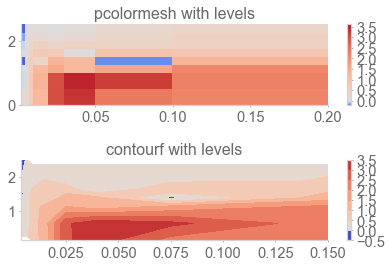

In [61]:
cmap = plt.get_cmap('coolwarm')
from matplotlib import colors
divnorm=colors.DivergingNorm(
    vmin=levels[0],
    vcenter=0.,
    vmax=levels[-1]
    )

fig, (ax0, ax1) = plt.subplots(nrows=2)

im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=divnorm)
fig.colorbar(im, ax=ax0)
ax0.set_title('pcolormesh with levels')

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax1.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., z, #levels=levels,
                  cmap=cmap, norm=divnorm)
fig.colorbar(cf, ax=ax1)
ax1.set_title('contourf with levels')

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap
fig.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6.4*2.25, 4.8/1.25))
sns.barplot(
    x='Label', y='Field Area',
    #hue='Spatial $\sigma$ (cm)', palette='mako',
    ax=ax, data=df
    )
plt.ylabel('Field Area', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=90, fontsize=dset_fontsize)

# Henrikson & Mosers 2010
mean_val = 0.0725; ci = 0.005
plt.axhline(mean_val, linestyle='--', color='blue')
ax.axhspan(mean_val-ci, mean_val+ci, facecolor='blue', alpha=0.2)

# Payne 2021
mean_val = 0.1186; ci = 0.0178
plt.axhline(mean_val, linestyle='--', color='red')
ax.axhspan(mean_val-ci, mean_val+ci, facecolor='red', alpha=0.2)

#plt.tight_layout()
plt.savefig('5a_aggregate_area.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6.4*2.25, 4.8/1.25))
sns.barplot(
    x='Label', y='Number of Fields',
    #hue='Spatial $\sigma$ (cm)', palette='mako',
    ax=ax, data=df
    )
plt.ylabel('Number of Fields', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=90, fontsize=dset_fontsize)

# Henrikson & Mosers 2010
mean_val = 1.6; ci = 0.167
plt.axhline(mean_val, linestyle='--', color='blue')
ax.axhspan(mean_val-ci, mean_val+ci, facecolor='blue', alpha=0.2)

# Payne 2021
mean_val = 1.3547; ci = 0.0934
plt.axhline(mean_val, linestyle='--', color='red')
ax.axhspan(mean_val-ci, mean_val+ci, facecolor='red', alpha=0.2)
plt.ylim(0.7, 2.5)
#plt.tight_layout()
plt.savefig('5a_aggregate_nfields.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6.4*2.25, 4.8/1.25))
sns.barplot(
    x='Label', y='Proportion with One Field',
    #hue='Spatial $\sigma$ (cm)', palette='mako',
    ax=ax, data=df
    )
plt.ylabel('One Field Only', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(fontsize=dset_fontsize, rotation=90)

# Henrikson & Mosers 2010
plt.axhline(0.57, linestyle='--', color='blue')
plt.axhline(0.532, linestyle='--', color='blue')

# Payne 2021
plt.axhline(0.565, linestyle='--', color='red')

#plt.tight_layout()
plt.savefig('5a_aggregate_onefield.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6.4*2.25, 4.8/1.25))
sns.barplot(
    x='Dataset', y='Spatial Information',
    hue='Spatial Sigma', palette='mako',
    ax=ax, data=df
    )
plt.ylabel('Spatial Information', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.tight_layout()
plt.savefig('5a_aggregate_info.png', dpi=300)
plt.show()